In [1]:
# This script will import data from the LocalAir Escooter-based sensors.
# Data is encryped by the sensors, and this script decryptes before converting it into a pandas dataframe
# and then visualising it.
# Data can either be retrieved from a speificied folder, where all of the .bin files will be imported,
# or it can be downloaded directly from the website which the sensors uploads to. To avoid downloading
# files unnecceraily a time range can be specified.
# Behaviour is controlled through the "source" flag.

# importing the relevent libaries
from speck import SpeckCipher
import sys
import os

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import json

import pytz
from datetime import datetime

import urllib.request, urllib.error, urllib.parse

import numpy as np

import matplotlib.pyplot as plt

import random

# some variables to control behvaiousr
pd.options.display.max_columns = None
# 'uploadFormat' is uesed to specify iif the file has come via being uplaoded, or if it is direct from
# the SD card. Something happens during the upload process that introduces a lot of new line charactors,
# and the software must get rid of these before it can process the file.
uploadFormat = False
numOfChunks = 60
source = 'Folder' # can be 'Download' for downloading direclty of the web, 
                    # or 'Folder' for reading from a folder

# If you are working with files in a folder then this is the name of the directory where the files are stored
# if you have downloaded this off git you will need to change this!
#directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/240330'
# above is an example folder that works well
#directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/240416/to_process'
directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/testing/240425_Glos'

# if you are downloading them straight from https://london.localair.uk/ then you will need to specify the
# time range. These are the times between which we are going to download and process the files
# the datetime function takes variable in the format 'datetime'(YEAR, MONTH, DAY, HOUR, MINUTE)
download_start = datetime(2023, 11, 15, 0, 0)
download_end = datetime(2023, 11, 17, 0, 0)

In [2]:
def speck_key_gen(key_size=256):
    return '{'+', '.join([hex(random.randint(0,255)) for i in range(int(key_size/8))])+'}'

In [3]:
# before converting to a data frame, all the data is going to go into a list of dicts, this list is called:
data = []

# and this is decode key for the spec incryption
#key_string = '{0xad, 0x1c, 0x4b, 0x6, 0x5c, 0x85, 0x2a, 0x48, 0xe4, 0xed, 0x33, 0x23, 0x4c, 0x9f, 0xed, 0x56, 0x23, 0x46, 0x59, 0xfa, 0x3c, 0x70, 0x82, 0x97, 0x45, 0xbd, 0x2b, 0xf1, 0xdc, 0xf4, 0xb6, 0xce}'
key_string = '{0x9c, 0xf4, 0xc0, 0x74, 0x62, 0x60, 0xee, 0xc4, 0xc5, 0x2c, 0xd1, 0x34, 0x61, 0xf5, 0xa3, 0xac, 0x15, 0xd3, 0xbe, 0x5d, 0x30, 0x26, 0xff, 0x0, 0xed, 0x9f, 0x75, 0x61, 0xa0, 0xd, 0xfa, 0x26}'

In [4]:
# the key string format above is how the teensy needs in, we convert it into an int for python thusly:
# we can convert into somethign this code can use by doing this:
key = [int(i,16) for i in key_string[1:-1].split(',')]

# and now with the key we can set up our Speck Decryptre
my_speck = SpeckCipher(int.from_bytes(bytes(key), byteorder='big'), key_size=256, block_size=128)

In [5]:
# A function to converting the slightly funny GPS lat and long format into decimalised degrees.
def ddmm_to_degrees(ddmm):
    degrees, minutes = ddmm.astype('float64').divmod(100)
    return (degrees + minutes/60)

# a functionf or getting rid of the '-' values which appear when the GPS hasn't got a fix.
def missing_data(series):
    return series == '-'

In [6]:
# This is the code we run when we are checking a specific folder.
if source == 'Folder':
    # to manage folder in a operating system agnostic way it is best to use the 'os' libary.
    # here we are turning the string in which the direactory was given into some more agnostic.
    directory = os.fsencode(directory_in_str)

    # we are going to iterate through the files in that directory
    for fileBytes in os.listdir(directory):
        # get the name of the file, to see if it has the correct extention 
        filename = os.fsdecode(fileBytes)
        # and if it does, we process it
        if filename.endswith(".txt"):
            print('Checking {}'.format(filename))
            # open the file
            with open(os.path.join(directory, fileBytes), 'r') as file:
                # we are going to keep track of the line we are on, just for the perpose of error messages.
                line_count = 0
                # go through the file line by line
                for line in file:
                    # check the line isn't blank
                    if line == '\n':
                        # skip it if is.
                        continue
                    if uploadFormat:
                        # this means that the file is in the funny format that you seem to get when
                        # uploading via Strings from the sensor to James's server. We have to convert 
                        # it into the normal format
                        while True:
                            line_part = file.readline()
                            if (line_part == '\n' or line_part == ''):
                                break
                            line = line.strip() + line_part.strip();
                    # we need a line encramter so that we can tell the user where there are errors
                    line_count = line_count + 1
                    # and this is going to be the string into which we save the decoded ascii
                    DecodedAsciiLine = ''

                    # each line is encoded into a number of encoded chunks, at the moment that number is 60,
                    # although it might change so I've put it in a variable.
                    for i in range(numOfChunks):
                        encChunk = line[i*32:(i*32)+32]
                        try:
                            CipherTextChunk = int(encChunk, 16)
                        except ValueError:
                            # the data we dealing with is rarely perfect, but least becasue the micro controller
                            # on sensor will always encrypt the same length of memory, even if the data does not
                            # fill it completely, this means there is almost always some random jibberish at the
                            # end. For reason almost all of this part of the processing is encased in tries.
                            # it is give it a go, and if it doesn't work it will output an error message and
                            # carry on with its day. It might be possible to do more to recover data that is 
                            # corrupted, but I haven't tried to do this yet.
                            print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                                # NOTE:'file=sys.stderr' means the message appears as an Error on a UNIX based OS
                                # I DON'T KNOW IF THIS WORKS ON WINDOWS... PROBABLY NOT. 
                                # this is the case for all of the tries in the below code.
                        PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                        # now decode the hex to ascii

                        try:
                            # convert to a byte array
                            # we cut off the first two characters because they are the '0x' signifing hex
                            PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                        except ValueError:
                            print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                        # each line ends with guff, so we have to look out for the null byte,
                        # which signifies the end.
                        # look for the null character
                        nullLoc = PlaneByteArray.find(b'\00')

                        # if the location returned is 0 or higher then there is a null character in there
                        # and we must ignore everything after it
                        if (nullLoc > -1):
                            try:
                                # This turns the int value that is returned by the decruption into an ascii
                                # array.
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        else:
                            try:
                                # if there was no null char then we do the whole string
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        # and concat the new block onto the exisiting string
                        DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                        # if we found the null character then we have reached the end of the message and can 
                        # break the loop
                        if (nullLoc > -1):
                            break
                    # now we are going to try and decode the json string and convert it into a nested data structure
                    try:
                        data.append(json.loads(DecodedAsciiLine.strip()))
                    except ValueError:
                        # if it doesn't work, then try and output it.
                        print('Error Decoding JSON in {}, on line {} - {}'.format(filename, line_count, DecodedAsciiLine),
                              file=sys.stderr
                             )
                continue
        else:
            continue

Checking AL_002_800105-235957.txt
Checking AL_002_240425-134912.txt
Checking AL_002_240425-130936.txt


Error Decoding JSON in AL_002_240425-130936.txt, on line 13 - {"datetime":"2024-04-25T13:10:46.219Z","GPS":{"fix":"False","location":{"lat":"-","long":"-","alt":"-"},"speed":"-","angle":"-","satellites":"-"},"DHT":{"humidity":60.9,"temp":13.1,"heat_index":12.06},"MultiGas":{"no2":20,"c2h5ch":144,"voc":152,"co":72},"PM_Sensor":{"atmos_enviro":{"AE_1.0":34,"AE_2.5":43,"AE_10.0":54}},"FFT":[3.42,6.35,4.58,9.28,11.41,9.4,6.65,2.87,9.95,9.52,3.6,4.94,7.69,11.41,11.47,5.55,3.42,2.38,2.69,2.44,1.46,0.98,0.73,1.1,1.22,1.59,2.44,2.62,2.2,1.89,1.1,1.4,1.71,1.59,0.98,1.22,1.89]},4.52,3.54]}
Error in AL_002_240425-130936.txt, line 19, chunk 33, count not convert to ascii
Error in AL_002_240425-130936.txt, line 19, chunk 34, count not convert to ascii
Error in AL_002_240425-130936.txt, line 19, chunk 35, count not convert to ascii
Error in AL_002_240425-130936.txt, line 19, chunk 36, count not convert to ascii
Error in AL_002_240425-130936.txt, line 19, chunk 37, count not convert to ascii
Error in

Checking AL_002_240425-134531.txt
Checking AL_002_240425-134712.txt
Checking AL_002_240425-134329.txt


Error Decoding JSON in AL_002_240425-130936.txt, on line 268 - {"datetime":"2024-04-25T13:34:57.000Z","GPS":{"fix":"True","location":{"lat":5151.472656,"long":215.0346985,"alt":2.900000095},"speed":7.429999828,"angle":301.9899902,"satellites":8},"DHT":{"humidity":63.6,"temp":11.5,"heat_index":10.37},"MultiGas":{"no2":18,"c2h5ch":132,"voc":76,"co":68},"PM_Sensor":{"atmos_enviro":{"AE_1.0":22,"AE_2.5":31,"AE_10.0":41}},"FFT":[1.1,18.13,25.63,21.12,8.91,11.66,15.63,12.39,11.47,11.17,18.74,18.01,11.54,8.73,10.5,17.88,8.06,2.44,6.71,9.09,4.76,2.5,2.5,5.37,3.11,5.07,4.88,1.46,1.71,0.92,1.65,2.38,2.44,1.95,1.28,2.14,3.17]}7,7.75]}
Error Decoding JSON in AL_002_240425-130936.txt, on line 285 - {"datetime":"2024-04-25T13:36:37.000Z","GPS":{"fix":"True","location":{"lat":5151.539063,"long":215.0417938,"alt":10.69999981},"speed":11.53999996,"angle":4.949999809,"satellites":8},"DHT":{"humidity":64.7,"temp":11.7,"heat_index":10.61},"MultiGas":{"no2":19,"c2h5ch":146,"voc":78,"co":72},"PM_Sensor":{"a

In [7]:
# This is the code we run if we are getting stuff directly from the website.
if source == 'Download':
    # specify the base link to the data.
    url = 'https://london.localair.uk/data/archive/'

    # make the request to that URL
    response = urllib.request.urlopen(url)

    # decode the responce to UTF-8. This is the form of HTML, which then needs some working with to get the
    # file names we are interested in.
    wc = response.read().decode('UTF-8')

    # we are going to create a dataframe of the files that are available, this will include the name and
    # the timestamp that that signfies. The two lists below are populated before being turned into a 
    # dataframe.
    fileName = []
    timestamp = []

    # split the responce into a list deliniated by double quotes and iteraate through it
    for i in wc.split('"'):
        # if this item ends with the characters '.bin' then it is a filename and we save it to our list.
        if i[-4:] == '.bin':
            fileName.append(i)
            # the file name is simply a timestamp with a '.bin' ending. We covert that into a datetime variable
            # and save that into the other list.
            timestamp.append(datetime.strptime(i, '%Y%m%d_%H%M%S_%f.bin'))
    
    # create the data frame.
    df_files = pd.DataFrame({'FileName':fileName, 'TimeStamp': timestamp})

    # no we mask out those files that are outside our specified range.
    mask = (df_files['TimeStamp'] > download_start) & (df_files['TimeStamp'] < download_end)
    
    # print a list of the file.
    print(df_files['TimeStamp'])
    
    # for through all the files that are in the time range.
    for file in df_files[mask]['FileName']:
        filename = file
        # download the file
        response = urllib.request.urlopen(url+file)
        # decode the file into utf-8
        wc = response.read().decode('UTF-8')
        line_count = 0
        # we process it in much the same way as we did with the files in a folder.
        # Although there are some differences as we now have to remove '\n' characters. Again, thismight
        # be different on windows.
        for line in wc.split('\n\n'):
            if line == '':
                continue
            line = line.replace('\n', "")
            # From here on in I think it's essentially the same as the cell above.
            # we need a line encramter so that we can tell the user where there are errors
            line_count = line_count + 1
            # and this is going to be the string into which we save the decoded ascii
            DecodedAsciiLine = ''

            # each line is encoded into a number of encoded chunks, at the moment that number is 60,
            # although it might change so I've put it in a variable.
            for i in range(numOfChunks):
                encChunk = line[i*32:(i*32)+32]
                try:
                    CipherTextChunk = int(encChunk, 16)
                except ValueError:
                    print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                # now decode the hex to ascii

                # so the message ends with guff, so we have to look out for the nulll byte,
                # which signifies the end.
                # convert to a byte array
                # we cut off the first two characters because they are the '0x' signifing hex
                try:
                    PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                except ValueError:
                    print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                    AsciiChunk = ''
                # look for the null character
                nullLoc = PlaneByteArray.find(b'\00')

                # if the location returned is 0 or higher then there is a null character in there
                # and we must ignore everything after it
                if (nullLoc > -1):
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                else:
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                # and concat the new block onto the exisiting string
                DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                # if we found the null character then we have reached the end of the message and can 
                # break the loop
                if (nullLoc > -1):
                    break
            # now we are going to try and decode the json string and convert it into a nested data structure
            try:
                data.append(json.loads(DecodedAsciiLine.strip()))
            except ValueError:
                # if it doesn't work, then try and output it.
                print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                      file=sys.stderr
                     )
        continue

In [8]:
if len(data) == 0:
    print("No data could be decoded. have you got the right key?")
else: 
    print("{} lines sucessfully decoded".format(len(data)))

346 lines sucessfully decoded


In [9]:
data

[{'datetime': '2080-01-05T00:00:02.094Z',
  'GPS': {'fix': 'False',
   'location': {'lat': '-', 'long': '-', 'alt': '-'},
   'speed': '-',
   'angle': '-',
   'satellites': '-'},
  'DHT': {'humidity': 42.7, 'temp': 17.4, 'heat_index': 16.31},
  'MultiGas': {'no2': 0, 'c2h5ch': 0, 'voc': 0, 'co': 0},
  'PM_Sensor': {'atmos_enviro': {'AE_1.0': 4, 'AE_2.5': 9, 'AE_10.0': 10}},
  'FFT': [0.37,
   1.89,
   4.64,
   2.2,
   2.99,
   4.46,
   5.49,
   1.59,
   0.55,
   5.8,
   3.17,
   2.81,
   3.66,
   2.62,
   2.75,
   3.97,
   3.72,
   3.3,
   0.98,
   1.53,
   2.08,
   2.32,
   2.62,
   2.62,
   3.17,
   4.76,
   4.76,
   4.52,
   4.58,
   2.87,
   3.97,
   4.27,
   3.48,
   0.73,
   1.04,
   0.12,
   0.92]},
 {'datetime': '2024-04-25T13:49:18.567Z',
  'GPS': {'fix': 'False',
   'location': {'lat': '-', 'long': '-', 'alt': '-'},
   'speed': '-',
   'angle': '-',
   'satellites': '-'},
  'DHT': {'humidity': 60.1, 'temp': 16, 'heat_index': 15.22},
  'MultiGas': {'no2': 179, 'c2h5ch': 259, '

In [10]:
# by the end of the previous cells the data was in a nest data struct, a list of dicts.
# we are goign to convert this into a dataframe.
df = pd.DataFrame(data)

# putting everything into a single flat df.
# the FFT bins are named after the frequency they capture.
df_flat = pd.concat([pd.to_datetime(df.datetime), 
           pd.json_normalize(df.GPS), 
           pd.json_normalize(df.DHT), 
           pd.json_normalize(df.MultiGas),
           pd.json_normalize(df.PM_Sensor),
           pd.DataFrame(df['FFT'].to_list(),columns = ['FFT.{}Hz'.format(i*43) for i in range(37)]),
           df.datetime.rename('datetime_str')
          ], axis=1)

# now we remove the '-' entries by using the missing_data function.
# this convert '-' into a 'Nan'
df_flat = df_flat.mask(missing_data)
# and we then just drop them
df_flat = df_flat.dropna()

# this means that only data for which a GPS fix existed remains. There is data that is valid,
# but for which there was no fix, and we will soemday want to do something with that.

# convert many columns into float values.
for col in ['speed', 'angle', 'satellites', 'location.lat', 'location.long', 'location.alt', 
            'humidity', 'temp', 'heat_index', 'no2', 'c2h5ch', 'voc', 'co', 
            'atmos_enviro.AE_1.0', 'atmos_enviro.AE_2.5', 'atmos_enviro.AE_10.0']:
    df_flat[col] = df_flat[col].astype('float')
    
# convert fix into a bool.
# (Which because of what we did before will always be True...)
df_flat['fix'] = df_flat['fix'].astype('bool')

# and print the shape of the df... just for good measure.
df.shape

(346, 6)

In [11]:
df_flat

,datetime,fix,speed,angle,satellites,location.lat,location.long,location.alt,humidity,temp,heat_index,no2,c2h5ch,voc,co,atmos_enviro.AE_1.0,atmos_enviro.AE_2.5,atmos_enviro.AE_10.0,FFT.0Hz,FFT.43Hz,FFT.86Hz,FFT.129Hz,FFT.172Hz,FFT.215Hz,FFT.258Hz,FFT.301Hz,FFT.344Hz,FFT.387Hz,FFT.430Hz,FFT.473Hz,FFT.516Hz,FFT.559Hz,FFT.602Hz,FFT.645Hz,FFT.688Hz,FFT.731Hz,FFT.774Hz,FFT.817Hz,FFT.860Hz,FFT.903Hz,FFT.946Hz,FFT.989Hz,FFT.1032Hz,FFT.1075Hz,FFT.1118Hz,FFT.1161Hz,FFT.1204Hz,FFT.1247Hz,FFT.1290Hz,FFT.1333Hz,FFT.1376Hz,FFT.1419Hz,FFT.1462Hz,FFT.1505Hz,FFT.1548Hz,datetime_str
92,2024-04-25 13:18:32+00:00,True,0.23,89.190002,4.0,5151.204590,215.003693,25.299999,62.4,12.8,11.76,21.0,147.0,113.0,76.0,9.0,14.0,14.0,11.17,13.98,12.70,3.42,4.15,9.64,16.97,16.05,5.92,4.64,16.11,17.76,15.44,56.03,43.88,13.37,8.73,13.43,2.08,11.47,16.72,15.44,10.50,13.06,9.83,3.30,1.77,2.62,1.16,0.79,0.31,0.61,2.26,2.81,2.99,2.01,3.42,2024-04-25T13:18:32.000Z
93,2024-04-25 13:18:37+00:00,True,4.66,120.099998,4.0,5151.201660,214.999298,25.299999,62.8,12.9,11.89,21.0,144.0,112.0,74.0,9.0,13.0,14.0,2.81,6.16,20.08,30.64,36.68,13.37,9.34,9.89,21.61,60.30,60.18,8.42,64.09,79.35,46.94,10.19,4.03,11.54,14.65,19.59,23.74,10.44,9.09,8.24,6.96,4.64,5.19,4.70,2.20,2.62,3.97,3.85,2.38,1.83,2.56,1.28,1.65,2024-04-25T13:18:37.000Z
94,2024-04-25 13:18:42+00:00,True,4.66,120.099998,5.0,5151.199219,214.994705,19.799999,63.2,12.9,11.90,19.0,139.0,112.0,72.0,9.0,14.0,14.0,3.54,6.53,14.53,7.87,11.66,14.83,1.95,3.36,25.09,37.90,23.01,23.62,27.95,81.30,81.85,36.01,8.12,1.71,11.17,20.02,9.58,1.53,2.38,1.89,1.83,3.72,2.81,0.85,0.73,1.71,2.69,0.73,1.34,1.83,1.28,1.28,1.04,2024-04-25T13:18:42.000Z
95,2024-04-25 13:18:47+00:00,True,2.70,103.470001,5.0,5151.197754,214.986999,19.799999,62.7,12.9,11.88,19.0,138.0,112.0,71.0,10.0,14.0,14.0,2.93,4.88,5.00,16.30,19.90,10.68,6.10,2.08,4.15,3.30,7.75,7.26,5.86,19.53,26.73,16.48,2.99,2.87,3.30,0.92,0.73,1.04,1.10,2.20,2.69,1.53,1.59,1.16,1.16,1.46,2.75,1.83,0.98,0.24,0.31,0.67,0.61,2024-04-25T13:18:47.000Z
96,2024-04-25 13:18:52+00:00,True,2.70,103.470001,6.0,5151.197754,214.983795,14.000000,62.5,12.9,11.88,22.0,152.0,113.0,80.0,9.0,15.0,15.0,0.31,1.77,3.05,2.99,1.34,4.64,4.03,1.95,3.85,4.94,4.39,2.08,1.46,1.04,3.60,0.67,1.28,1.46,2.69,2.01,1.83,0.55,0.43,1.89,2.87,1.10,0.73,0.79,0.85,1.28,0.18,1.10,1.40,0.61,0.92,0.61,0.67,2024-04-25T13:18:52.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2024-04-25 13:41:42+00:00,True,0.10,94.290001,8.0,5151.369141,215.069397,7.000000,63.4,12.2,11.13,20.0,141.0,79.0,72.0,11.0,16.0,21.0,10.19,7.75,7.93,9.34,9.09,15.32,10.01,8.12,11.78,17.88,22.83,23.13,19.47,25.33,14.89,17.27,22.03,8.67,3.85,3.48,2.38,4.33,4.46,3.23,3.72,1.89,1.10,0.67,0.92,2.01,2.69,1.95,1.89,0.73,1.28,1.34,1.40,2024-04-25T13:41:42.000Z
320,2024-04-25 13:41:47+00:00,True,0.10,94.290001,8.0,5151.369629,215.065002,7.800000,63.1,12.2,11.12,20.0,140.0,78.0,71.0,12.0,16.0,20.0,8.00,12.08,11.05,9.95,10.74,11.96,9.58,8.67,4.15,6.29,9.64,9.89,1.16,8.79,9.16,14.89,10.99,5.92,3.60,2.44,1.40,2.50,1.89,0.18,2.56,1.71,1.10,1.59,2.01,1.28,1.22,0.37,1.34,0.85,0.73,0.43,0.37,2024-04-25T13:41:47.000Z
321,2024-04-25 13:41:52+00:00,True,0.94,94.290001,8.0,5151.369141,215.059906,7.800000,63.0,12.2,11.12,20.0,142.0,78.0,71.0,13.0,18.0,19.0,1.22,4.88,17.33,11.23,16.78,21.67,5.49,6.35,3.36,4.58,6.84,2.56,4.33,6.96,7.51,10.13,9.64,2.08,2.32,2.87,2.26,2.01,2.93,2.38,2.69,2.32,2.20,1.46,1.34,1.10,1.22,2.14,1.65,1.22,1.16,2.26,2.75,2024-04-25T13:41:52.000Z
322,2024-04-25 13:41:57+00:00,True,0.94,94.290001,8.0,5151.365723,215.052795,8.700000,63.0,12.2,11.12,20.0,142.0,79.0,72.0,13.0,18.0,20.0,0.98,4.33,4.94,4.64,6.10,3.54,2.44,2.93,0.37,1.40,5.43,9.34,8.54,3.54,9.09,6.65,3.30,0.85,0.37,0.73,3.66,3.78,1.77,2.08,3.11,2.93,1.95,1.04,1.46,0.37,1.71,2.56,2.26,0.92,1.28,1.71,1.16,2024-04-25T1

In [12]:
# Geopandas essentially works by adding a few extra Geopandas specific location columns to the end 
# of a normal data frame. We create the values for those columns unsing the lat and long, and the
# 'ddm_to_degrees' function.
df_flat = gpd.GeoDataFrame(
    df_flat, 
    geometry=gpd.points_from_xy(-df_flat['location.long'].pipe(ddmm_to_degrees), 
                                df_flat['location.lat'].pipe(ddmm_to_degrees), 
                                crs='epsg:4326')
)

In [13]:
# If you want the size of te markers to chaneg based on a different value, this is the command:
#
# style_kwds={"style_function":lambda x: {"radius": (10 - x['properties']['satellites'])*2
#                                                                  }

In [14]:
# we can now use the 'explore' function in Geopandas to visualise the data.
map = df_flat[['datetime_str',
      'satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('co', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=None,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

map.save('map_co.html')
map

In [15]:
# we can now use the 'explore' function in Geopandas to visualise the data.
map = df_flat[['datetime_str',
      'satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('no2', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=None,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )


map.save('map_no2.html')
map

In [16]:
# here we are filterout values that are not between start_time and end_time.
start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 19, 0, 0))
end_time = pytz.timezone('UTC').localize(datetime(2024, 11, 15, 0, 0))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

# we then visualise the result
map = df_flat[mask][['datetime_str',
      'satellites',
      'FFT.215Hz',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('atmos_enviro.AE_10.0', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=None,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

map.save('map_pm.html')
map

Corrilation: -0.30739915740877705


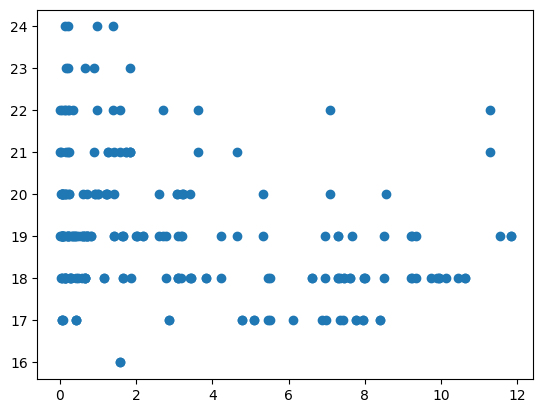

In [17]:
# Now we just produse some other plots, looking at corrolations between diferent values.
x_value = 'speed'
y_value = 'no2'

print('Corrilation: {}'.format(df_flat[x_value].corr(df_flat[y_value])))

plt.scatter(x=df_flat[x_value], y=df_flat[y_value])
plt.show()

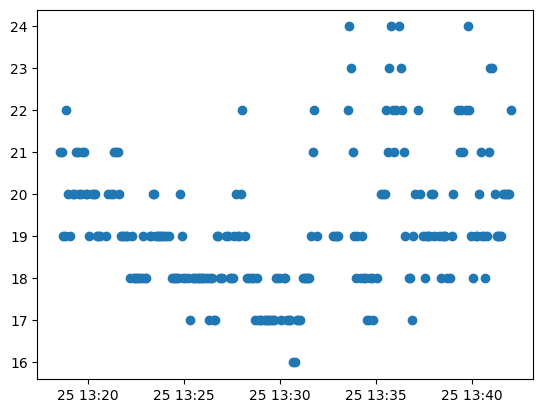

In [18]:
# simply plotting values against time.
plt.plot(df_flat['datetime'],df_flat['no2'],'o')
plt.show()

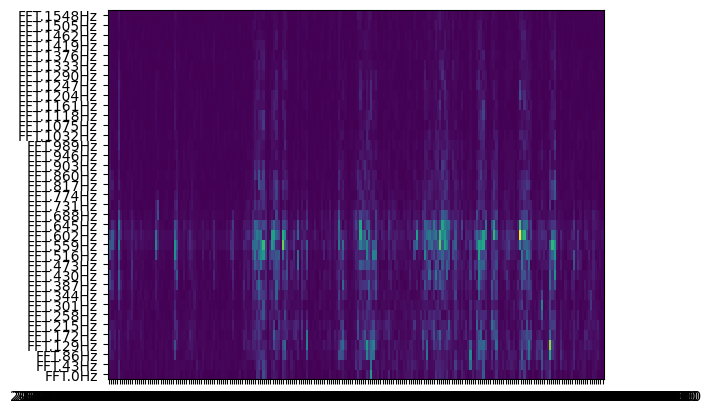

In [19]:
# produucing a spectrogram of the audio data.
bins = df_flat.filter(like='FFT').columns

plt.pcolor(df_flat.filter(like='FFT').T)
plt.yticks(np.arange(0.5, bins.size, 1), bins)
plt.xticks(np.arange(0.5, len(df_flat.index), 1), df_flat.datetime)
plt.show()

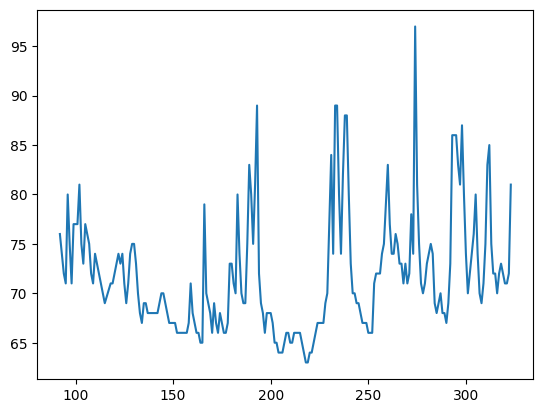

In [20]:
# plot against measurement reading rather than time. (no gaps)
plt.plot(df_flat.co)
plt.show()

In [21]:
# if we want to filter out some part of the data based on time, this is how we do it.

start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 23, 10, 55))
end_time = datetime.now(pytz.timezone('UTC'))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

In [22]:
# we can then get only those rows that are within the time range we are looking for by dooing this:
df_flat[mask]

,datetime,fix,speed,angle,satellites,location.lat,location.long,location.alt,humidity,temp,heat_index,no2,c2h5ch,voc,co,atmos_enviro.AE_1.0,atmos_enviro.AE_2.5,atmos_enviro.AE_10.0,FFT.0Hz,FFT.43Hz,FFT.86Hz,FFT.129Hz,FFT.172Hz,FFT.215Hz,FFT.258Hz,FFT.301Hz,FFT.344Hz,FFT.387Hz,FFT.430Hz,FFT.473Hz,FFT.516Hz,FFT.559Hz,FFT.602Hz,FFT.645Hz,FFT.688Hz,FFT.731Hz,FFT.774Hz,FFT.817Hz,FFT.860Hz,FFT.903Hz,FFT.946Hz,FFT.989Hz,FFT.1032Hz,FFT.1075Hz,FFT.1118Hz,FFT.1161Hz,FFT.1204Hz,FFT.1247Hz,FFT.1290Hz,FFT.1333Hz,FFT.1376Hz,FFT.1419Hz,FFT.1462Hz,FFT.1505Hz,FFT.1548Hz,datetime_str,geometry
92,2024-04-25 13:18:32+00:00,True,0.23,89.190002,4.0,5151.204590,215.003693,25.299999,62.4,12.8,11.76,21.0,147.0,113.0,76.0,9.0,14.0,14.0,11.17,13.98,12.70,3.42,4.15,9.64,16.97,16.05,5.92,4.64,16.11,17.76,15.44,56.03,43.88,13.37,8.73,13.43,2.08,11.47,16.72,15.44,10.50,13.06,9.83,3.30,1.77,2.62,1.16,0.79,0.31,0.61,2.26,2.81,2.99,2.01,3.42,2024-04-25T13:18:32.000Z,POINT (-2.25006 51.85341)
93,2024-04-25 13:18:37+00:00,True,4.66,120.099998,4.0,5151.201660,214.999298,25.299999,62.8,12.9,11.89,21.0,144.0,112.0,74.0,9.0,13.0,14.0,2.81,6.16,20.08,30.64,36.68,13.37,9.34,9.89,21.61,60.30,60.18,8.42,64.09,79.35,46.94,10.19,4.03,11.54,14.65,19.59,23.74,10.44,9.09,8.24,6.96,4.64,5.19,4.70,2.20,2.62,3.97,3.85,2.38,1.83,2.56,1.28,1.65,2024-04-25T13:18:37.000Z,POINT (-2.24999 51.85336)
94,2024-04-25 13:18:42+00:00,True,4.66,120.099998,5.0,5151.199219,214.994705,19.799999,63.2,12.9,11.90,19.0,139.0,112.0,72.0,9.0,14.0,14.0,3.54,6.53,14.53,7.87,11.66,14.83,1.95,3.36,25.09,37.90,23.01,23.62,27.95,81.30,81.85,36.01,8.12,1.71,11.17,20.02,9.58,1.53,2.38,1.89,1.83,3.72,2.81,0.85,0.73,1.71,2.69,0.73,1.34,1.83,1.28,1.28,1.04,2024-04-25T13:18:42.000Z,POINT (-2.24991 51.85332)
95,2024-04-25 13:18:47+00:00,True,2.70,103.470001,5.0,5151.197754,214.986999,19.799999,62.7,12.9,11.88,19.0,138.0,112.0,71.0,10.0,14.0,14.0,2.93,4.88,5.00,16.30,19.90,10.68,6.10,2.08,4.15,3.30,7.75,7.26,5.86,19.53,26.73,16.48,2.99,2.87,3.30,0.92,0.73,1.04,1.10,2.20,2.69,1.53,1.59,1.16,1.16,1.46,2.75,1.83,0.98,0.24,0.31,0.67,0.61,2024-04-25T13:18:47.000Z,POINT (-2.24978 51.85330)
96,2024-04-25 13:18:52+00:00,True,2.70,103.470001,6.0,5151.197754,214.983795,14.000000,62.5,12.9,11.88,22.0,152.0,113.0,80.0,9.0,15.0,15.0,0.31,1.77,3.05,2.99,1.34,4.64,4.03,1.95,3.85,4.94,4.39,2.08,1.46,1.04,3.60,0.67,1.28,1.46,2.69,2.01,1.83,0.55,0.43,1.89,2.87,1.10,0.73,0.79,0.85,1.28,0.18,1.10,1.40,0.61,0.92,0.61,0.67,2024-04-25T13:18:52.000Z,POINT (-2.24973 51.85330)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2024-04-25 13:41:42+00:00,True,0.10,94.290001,8.0,5151.369141,215.069397,7.000000,63.4,12.2,11.13,20.0,141.0,79.0,72.0,11.0,16.0,21.0,10.19,7.75,7.93,9.34,9.09,15.32,10.01,8.12,11.78,17.88,22.83,23.13,19.47,25.33,14.89,17.27,22.03,8.67,3.85,3.48,2.38,4.33,4.46,3.23,3.72,1.89,1.10,0.67,0.92,2.01,2.69,1.95,1.89,0.73,1.28,1.34,1.40,2024-04-25T13:41:42.000Z,POINT (-2.25116 51.85615)
320,2024-04-25 13:41:47+00:00,True,0.10,94.290001,8.0,5151.369629,215.065002,7.800000,63.1,12.2,11.12,20.0,140.0,78.0,71.0,12.0,16.0,20.0,8.00,12.08,11.05,9.95,10.74,11.96,9.58,8.67,4.15,6.29,9.64,9.89,1.16,8.79,9.16,14.89,10.99,5.92,3.60,2.44,1.40,2.50,1.89,0.18,2.56,1.71,1.10,1.59,2.01,1.28,1.22,0.37,1.34,0.85,0.73,0.43,0.37,2024-04-25T13:41:47.000Z,POINT (-2.25108 51.85616)
321,2024-04-25 13:41:52+00:00,True,0.94,94.290001,8.0,5151.369141,215.059906,7.800000,63.0,12.2,11.12,20.0,142.0,78.0,71.0,13.0,18.0,19.0,1.22,4.88,17.33,11.23,16.78,21.67,5.49,6.35,3.36,4.58,6.84,2.56,4.33,6.96,7.51,10.13,9.64,2.08,2.32,2.87,2.26,2.01,2.93,2.38,2.69,2.32,2.20,1.46,1.34,1.10,1.22,2.14,1.65,1.22,1.16,2.26,2.75,2024-04-25T13:41:52.000Z,POINT (-2.25100 51.85615)
322,2024-04-25 13:41:57+00:00,True,0.94,94.290001,8.0,5151.365723,215.052795,8.700000,63.0,12.2,11.12,20.0,142.0,7

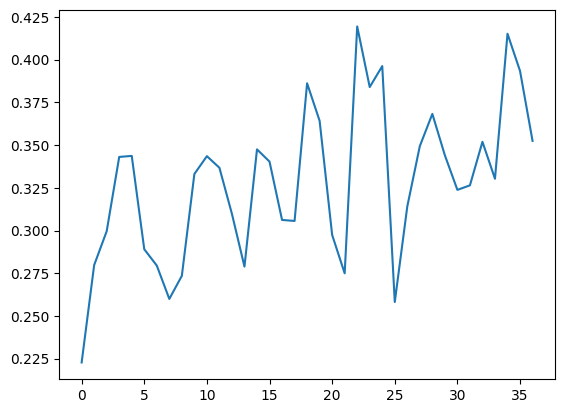

In [23]:
# foring through all the FFT bins to see if any of them corrolate well with other values.
freq=[]
corr=[]
for bin in bins:
    freq.append(bin)
    corr.append(df_flat[mask]['atmos_enviro.AE_10.0'].corr(df_flat[mask][bin]))

# results are saved to a list for that they can be plotted.
df_FFTCorrilation = pd.DataFrame({'Frequency':freq, 'Corrilation':corr})
df_FFTCorrilation

plt.plot(df_FFTCorrilation['Corrilation'])
plt.show()

Corrilation: 0.7384770717836011


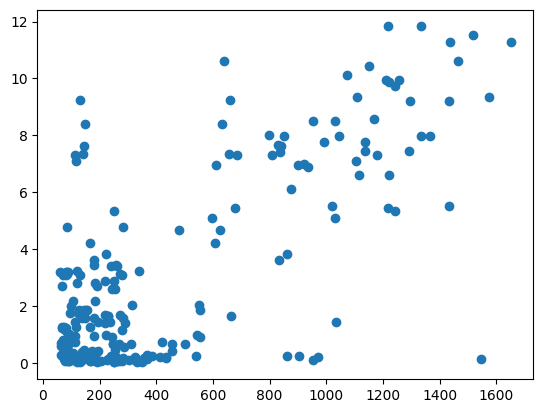

In [24]:
# more corralation stuff
print('Corrilation: {}'.format(df_flat.filter(like='FFT').sum(axis='columns').corr(df_flat[mask]['speed'])))

plt.scatter(df_flat[mask].filter(like='FFT').sum(axis='columns'), df_flat[mask]['speed'])
plt.show()

In [28]:
df_flat['tot_noice'] = df_flat.filter(like='FFT').sum(axis='columns')

In [29]:
# here we are filterout values that are not between start_time and end_time.
start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 19, 0, 0))
end_time = pytz.timezone('UTC').localize(datetime(2024, 11, 15, 0, 0))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

# we then visualise the result
map = df_flat[mask][['datetime_str',
      'satellites',
      'FFT.215Hz',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'tot_noice',
      'geometry']].explore('tot_noice', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=None,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

map.save('map_noice.html')
map

In [31]:
df_flat.dtypes

datetime                datetime64[ns, UTC]
fix                                    bool
speed                               float64
angle                               float64
satellites                          float64
location.lat                        float64
location.long                       float64
location.alt                        float64
humidity                            float64
temp                                float64
heat_index                          float64
no2                                 float64
c2h5ch                              float64
voc                                 float64
co                                  float64
atmos_enviro.AE_1.0                 float64
atmos_enviro.AE_2.5                 float64
atmos_enviro.AE_10.0                float64
FFT.0Hz                             float64
FFT.43Hz                            float64
FFT.86Hz                            float64
FFT.129Hz                           float64
FFT.172Hz                       

In [34]:
for col in df_flat.columns:
    if pd.api.types.is_numeric_dtype(df_flat[col]):
        this_corr = df_flat[col].corr(df_flat['speed'])
        print('{}: {}'.format(col, this_corr))

fix: nan
speed: 1.0
angle: 0.0035257403255017157
satellites: 0.1510242902045057
location.lat: 0.1692102896057731
location.long: -0.06048167577113144
location.alt: -0.00998632823205258
humidity: 0.17256834872272986
temp: -0.1478713444679538
heat_index: -0.14199411260811143
no2: -0.30739915740877705
c2h5ch: -0.20786087177214604
voc: -0.14613009179634875
co: -0.2928743680129543
atmos_enviro.AE_1.0: 0.6370649307842505
atmos_enviro.AE_2.5: 0.5863348974391165
atmos_enviro.AE_10.0: 0.520136299215178
FFT.0Hz: 0.3728121966816797
FFT.43Hz: 0.34038529429536735
FFT.86Hz: 0.3947422004116594
FFT.129Hz: 0.46099298427834634
FFT.172Hz: 0.5373972898748524
FFT.215Hz: 0.42950450422023634
FFT.258Hz: 0.3995943146804052
FFT.301Hz: 0.37193972595896146
FFT.344Hz: 0.5278382770691572
FFT.387Hz: 0.6009017554778291
FFT.430Hz: 0.6077862713215483
FFT.473Hz: 0.6343797268652981
FFT.516Hz: 0.6452541807239002
FFT.559Hz: 0.6458186769038443
FFT.602Hz: 0.61144700123072
FFT.645Hz: 0.5671542745779022
FFT.688Hz: 0.50178476466